In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization

In [120]:
data_path = "/home/comet/Documents/KAIST/Data-driven/IE437_HW2/data/log.csv"

data = pd.read_csv(data_path)
print(data)

             A         B         C         D         E      score
0     0.185171  0.012469  0.643883  0.000518  0.706477  64.948380
1     0.109382  0.264447  0.830440  0.936024  0.152748  67.864240
2     0.879817  0.268302  0.687127  0.694333  0.049413  72.356650
3     0.015239  0.792621  0.065918  0.493001  0.010857  69.130690
4     0.021096  0.480832  0.964605  0.124905  0.399937  65.814804
...        ...       ...       ...       ...       ...        ...
9987  0.588501  0.666145  0.692200  0.643742  0.299264  76.598465
9988  0.203448  0.201929  0.131689  0.419674  0.506553  71.323395
9989  0.945315  0.433905  0.629868  0.453814  0.964182  69.772125
9990  0.863595  0.919242  0.512188  0.706161  0.752385  74.662800
9991  0.228581  0.622028  0.558186  0.302629  0.844547  68.673020

[9992 rows x 6 columns]


<Figure size 960x660 with 0 Axes>

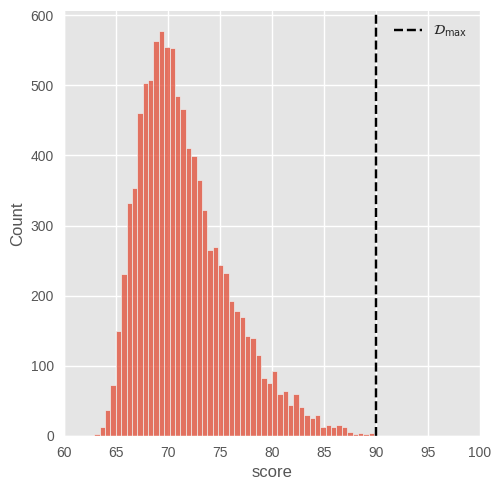

In [122]:
# Visualize Data Distribution
plt.style.use("ggplot")
plt.figure(dpi=120)
sns.displot(data['score'])
plt.xlim(60, 100)
plt.axvline(90, linestyle="--", color="black", label="$\mathcal{D}_{\max}$")
plt.legend()

<Figure size 960x660 with 0 Axes>

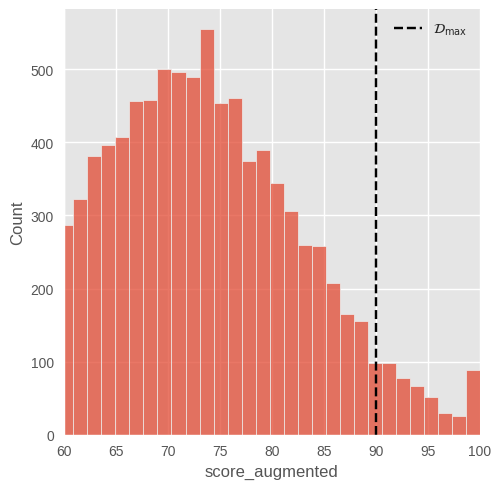

In [97]:
# Data Augmentation
# noise = np.random.normal(0, 10, data.shape[0])
# data['score_augmented'] = np.clip(data['score'] + noise, 0, 100)

# Visualize Data Distribution
plt.style.use("ggplot")
plt.figure(dpi=120)
sns.displot(data['score_augmented'])
plt.xlim(60, 100)
plt.axvline(90, linestyle="--", color="black", label="$\mathcal{D}_{\max}$")
plt.legend()


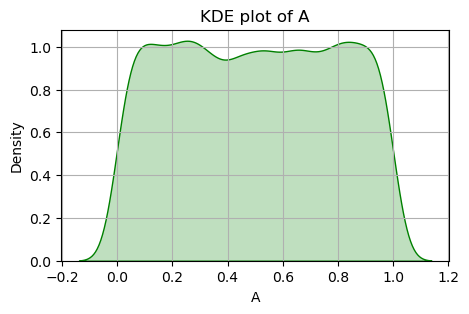

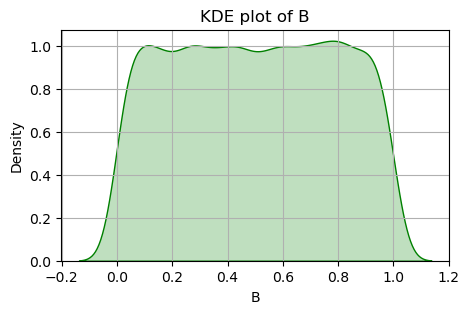

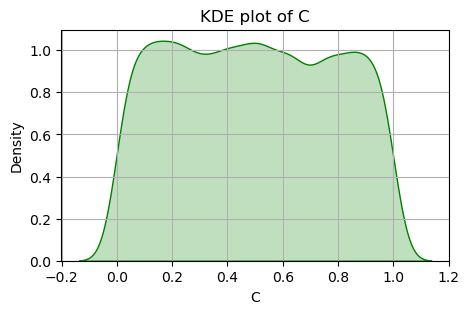

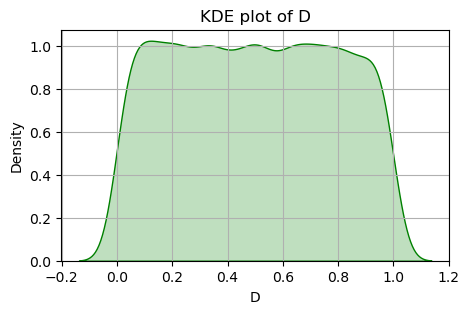

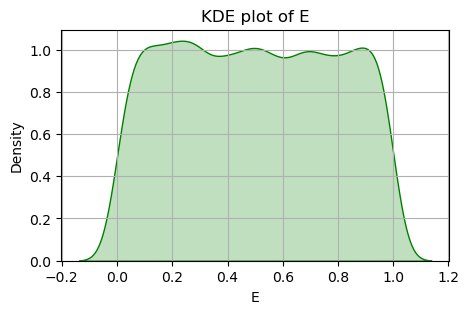

In [3]:
import seaborn as sns

# Visualize Data Distribution using KDE plot
for column in ['A', 'B', 'C', 'D', 'E']:
    plt.figure(figsize=(5, 3))
    sns.kdeplot(data[column], color='g', fill=True)
    plt.title(f'KDE plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

In [136]:
from pycaret.regression import *

exp_reg = setup(data = data, target = 'score', session_id = 123)

,Description,Value
0,Session id,123
1,Target,score
2,Target type,Regression
3,Original data shape,"(9992, 6)"
4,Transformed data shape,"(9992, 6)"
5,Transformed train set shape,"(6994, 6)"
6,Transformed test set shape,"(2998, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [124]:
best = compare_models(sort = 'MAE', n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.3593,0.2159,0.4640,0.9885,0.0063,0.0050,0.8150
et,Extra Trees Regressor,0.5240,0.4500,0.6705,0.9760,0.0091,0.0073,0.0470
gbr,Gradient Boosting Regressor,0.5413,0.6439,0.8007,0.9657,0.0103,0.0074,0.0790
rf,Random Forest Regressor,0.5680,0.5340,0.7301,0.9715,0.0098,0.0079,0.0960
knn,K Neighbors Regressor,0.6692,0.7282,0.8528,0.9611,0.0115,0.0093,0.0060
dt,Decision Tree Regressor,0.9153,1.4306,1.1955,0.9237,0.0160,0.0126,0.0070
ada,AdaBoost Regressor,1.7261,4.2255,2.0550,0.7743,0.0282,0.0243,0.0350
huber,Huber Regressor,1.8406,6.2586,2.4993,0.6666,0.0329,0.0251,0.0050
ridge,Ridge Regression,1.8618,6.1489,2.4775,0.6724,0.0328,0.0255,0.0040
br,Bayesian Ridge,1.8624,6.1489,2.4775,0.6724,0.0328,0.0255,0.0040


In [125]:
# 선택한 모델들을 앙상블
blended = blend_models(estimator_list=best)

# 앙상블 모델 학습
final_model = finalize_model(blended)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3791,0.2873,0.5360,0.9857,0.0069,0.0052
1,0.3765,0.2751,0.5245,0.9852,0.0069,0.0052
2,0.4383,0.3783,0.6151,0.9800,0.0079,0.0060
3,0.4007,0.2783,0.5275,0.9851,0.0070,0.0055
4,0.3711,0.2545,0.5044,0.9864,0.0066,0.0051
5,0.3996,0.2945,0.5426,0.9847,0.0071,0.0055
6,0.3992,0.2859,0.5347,0.9848,0.0071,0.0055
7,0.4034,0.2879,0.5366,0.9845,0.0071,0.0056
8,0.3737,0.2368,0.4866,0.9869,0.0065,0.0051


In [142]:
print(final_model)
prediction = predict_model(final_model, data=data)
print(prediction)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['A', 'B', 'C', 'D', 'E'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 VotingRegressor(estimators=[('Light Gradient Boosting Machine',
                                              LGBMRegressor(n_jobs=-1,
                                                            random_state=123)),
                                             ('Extra Trees Regressor',
                                              ExtraTreesRegressor(n_jobs=-1,
                                                                  random_state=123)),
                                             ('Gradient Boosting Regressor',
                          

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.2148,0.0895,0.2992,0.9952,0.0039,0.0029


             A         B         C         D         E      score  \
0     0.185171  0.012469  0.643883  0.000518  0.706477  64.948380   
1     0.109382  0.264447  0.830440  0.936024  0.152748  67.864243   
2     0.879817  0.268302  0.687127  0.694333  0.049413  72.356651   
3     0.015239  0.792621  0.065918  0.493001  0.010857  69.130692   
4     0.021096  0.480832  0.964605  0.124905  0.399937  65.814804   
...        ...       ...       ...       ...       ...        ...   
9987  0.588501  0.666145  0.692200  0.643742  0.299264  76.598465   
9988  0.203448  0.201929  0.131689  0.419674  0.506553  71.323395   
9989  0.945315  0.433905  0.629868  0.453814  0.964182  69.772125   
9990  0.863595  0.919242  0.512188  0.706161  0.752385  74.662804   
9991  0.228581  0.622028  0.558186  0.302629  0.844547  68.673019   

      prediction_label  
0            64.796645  
1            67.920226  
2            72.351737  
3            69.397776  
4            65.321493  
...                ..

In [113]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [114]:
# hyperparameter tuning 
tuned_model = tune_model(final_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3649,0.2608,0.5107,0.9870,0.0066,0.0050
1,0.3597,0.2553,0.5052,0.9862,0.0066,0.0049
2,0.4181,0.3409,0.5838,0.9819,0.0075,0.0057
3,0.3843,0.2648,0.5146,0.9858,0.0068,0.0053
4,0.3519,0.2279,0.4773,0.9878,0.0063,0.0048
5,0.3916,0.2834,0.5323,0.9853,0.0070,0.0053
6,0.4005,0.2849,0.5338,0.9848,0.0071,0.0055
7,0.3842,0.2618,0.5116,0.9859,0.0068,0.0053
8,0.3572,0.2163,0.4651,0.9881,0.0062,0.0049


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [151]:
def blackbox_function(A, B, C, D, E):
    # 입력 데이터 프레임 생성
    input_data = pd.DataFrame([[A, B, C, D, E]], columns=['A', 'B', 'C', 'D', 'E'])
    
    # 예측 모델 사용
    prediction = predict_model(final_model, data=input_data)

    # 예측 열의 이름 찾기
    label_col = prediction.columns[-1]

    # 예측 값 반환 - 마지막 열의 첫 번째 값을 반환
    return prediction[label_col].iloc[0]

In [152]:
pbounds = {
    'A': (data['A'].min(), data['A'].max()),
    'B': (data['B'].min(), data['B'].max()),
    'C': (data['C'].min(), data['C'].max()),
    'D': (data['D'].min(), data['D'].max()),
    'E': (data['E'].min(), data['E'].max())
}
# pbounds = {'A': (0, 1), 'B': (0, 1), 'C': (0, 1), 'D': (0, 1), 'E': (0, 1)}

# Bayesian Optimization
optimizer = BayesianOptimization(f=blackbox_function, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)

|   iter    |  target   |     A     |     B     |     C     |     D     |     E     |
-------------------------------------------------------------------------------------


| 1         | 71.4      | 0.3745    | 0.9507    | 0.732     | 0.5987    | 0.1562    |


| 2         | 66.87     | 0.156     | 0.05809   | 0.8661    | 0.6012    | 0.7081    |


| 3         | 65.64     | 0.02064   | 0.9699    | 0.8324    | 0.2124    | 0.182     |


| 4         | 71.5      | 0.1834    | 0.3042    | 0.5249    | 0.432     | 0.2914    |


| 5         | 73.66     | 0.6118    | 0.1395    | 0.2924    | 0.3664    | 0.4562    |


| 6         | 73.89     | 0.7851    | 0.1997    | 0.5144    | 0.5925    | 0.04667   |


| 7         | 72.1      | 0.6075    | 0.1705    | 0.06542   | 0.9489    | 0.9656    |


| 8         | 81.9      | 0.8083    | 0.3046    | 0.09802   | 0.6843    | 0.4403    |


| 9         | 74.35     | 0.1221    | 0.4952    | 0.03477   | 0.9093    | 0.2589    |


| 10        | 76.37     | 0.6625    | 0.3117    | 0.5202    | 0.5468    | 0.185     |


| 11        | 85.16     | 0.8446    | 0.5794    | 0.1186    | 0.7203    | 0.3364    |


| 12        | 77.18     | 0.9999    | 0.8299    | 0.000397  | 0.4921    | 0.5498    |


| 13        | 80.56     | 0.9999    | 0.5451    | 0.000397  | 1.0       | 0.187     |


| 14        | 81.71     | 0.9717    | 0.6294    | 0.3989    | 0.8971    | 0.4678    |


| 15        | 77.9      | 0.7812    | 0.6544    | 0.000397  | 0.5322    | 0.0002333 |


| 16        | 83.57     | 0.6955    | 0.7813    | 0.06263   | 0.9686    | 0.4571    |


| 17        | 69.48     | 0.07551   | 0.8119    | 0.4668    | 0.3059    | 0.2989    |


| 18        | 69.72     | 0.08255   | 0.9038    | 0.5938    | 0.7498    | 0.7481    |


| 19        | 69.09     | 0.728     | 0.6674    | 0.9944    | 0.4067    | 0.5388    |


| 20        | 86.56     | 0.6699    | 0.5788    | 0.2549    | 0.8915    | 0.2915    |


| 21        | 78.96     | 0.7434    | 0.8873    | 0.3051    | 1.0       | 0.09566   |


| 22        | 85.09     | 0.7208    | 0.4682    | 0.1688    | 1.0       | 0.4       |


| 23        | 86.83     | 0.6442    | 0.6005    | 0.2143    | 0.77      | 0.4489    |


| 24        | 84.84     | 0.5522    | 0.5674    | 0.03574   | 0.7476    | 0.3727    |


| 25        | 86.97     | 0.7104    | 0.5805    | 0.1645    | 0.8371    | 0.3841    |


| 26        | 86.66     | 0.6661    | 0.5279    | 0.2299    | 0.7655    | 0.3396    |


| 27        | 86.87     | 0.6446    | 0.5853    | 0.2613    | 0.8362    | 0.3981    |


| 28        | 86.49     | 0.6629    | 0.684     | 0.2165    | 0.7575    | 0.3549    |


| 29        | 86.9      | 0.7268    | 0.5935    | 0.2515    | 0.8035    | 0.3894    |


| 30        | 87.01     | 0.664     | 0.6007    | 0.1987    | 0.8121    | 0.3725    |


| 31        | 86.82     | 0.7056    | 0.6035    | 0.1646    | 0.772     | 0.4244    |


| 32        | 86.8      | 0.7059    | 0.5427    | 0.223     | 0.8409    | 0.371     |


| 33        | 86.44     | 0.6864    | 0.6876    | 0.2793    | 0.8292    | 0.4917    |


| 34        | 66.34     | 0.3955    | 1.0       | 0.000397  | 0.0001257 | 1.0       |


| 35        | 86.77     | 0.7082    | 0.6311    | 0.2206    | 0.8693    | 0.3979    |


| 36        | 85.18     | 0.6699    | 0.5246    | 0.0698    | 0.8965    | 0.2503    |


| 37        | 66.4      | 0.9999    | 1.0       | 0.9999    | 1.0       | 1.0       |


| 38        | 86.64     | 0.6538    | 0.6385    | 0.3204    | 0.7762    | 0.3744    |


| 39        | 86.32     | 0.6877    | 0.5888    | 0.1546    | 0.8556    | 0.5056    |


| 40        | 86.97     | 0.7049    | 0.5965    | 0.203     | 0.8043    | 0.3395    |


In [30]:
# 베이지안 최적화로 튜닝한 모델
tuned_model = tune_model(model, custom_grid = {'learning_rate': [res.x[0]], 'n_estimators': [res.x[1]]})

# 모델 성능 평가
evaluate_model(tuned_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7385,0.9187,0.9585,0.9544,0.0130,0.0102
1,0.7721,1.0220,1.0110,0.9448,0.0137,0.0107
2,0.7016,0.8565,0.9255,0.9546,0.0125,0.0097
3,0.6520,0.6823,0.8260,0.9634,0.0113,0.0091
4,0.6796,0.7730,0.8792,0.9585,0.0121,0.0095
5,0.6938,0.8323,0.9123,0.9569,0.0124,0.0096
6,0.7665,1.0118,1.0059,0.9461,0.0136,0.0106
7,0.6637,0.7531,0.8678,0.9594,0.0119,0.0093
8,0.7051,0.8243,0.9079,0.9545,0.0123,0.0098


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6294, number of used features: 5
[LightGBM] [Info] Start training from score 71.595492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6295, number of used features: 5
[LightGBM] [Info] Start training from score 71.645375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 629

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [74]:
columns = ['A', 'B', 'C', 'D', 'E']
for column in columns:
    min_val = data[column].min()
    max_val = data[column].max()
    print(f'Range of {column}: {min_val} to {max_val}')

# column min, max -> (0, 1)

Range of A: 6.431341e-05 to 0.9998598
Range of B: 1.0311604e-05 to 0.9999685
Range of C: 0.00039696693 to 0.999882
Range of D: 0.0001257062 to 0.9999964
Range of E: 0.00023329258 to 0.9999871


In [34]:
from pycaret.regression import *
from skopt import gp_minimize
from skopt.space import Real
import numpy as np

# 데이터 불러오기
# 데이터를 불러와 X_train, y_train에 할당합니다.

# LightGBM 모델 학습
# exp = setup(data=data, target='score', silent=True)
lgbm = create_model('lightgbm')

# 목적 함수 정의: 모델의 예측값을 최대화
def objective_function(x):
    # 입력값을 모델에 적용하여 예측값을 계산합니다.
    prediction = predict_model(lgbm, data=pd.DataFrame([x], columns=data.iloc[:, :-1].columns))
    # 예측값을 최대화하기 위해 음수를 반환합니다.
    return -prediction['Label'][0]

# 입력값의 범위 정의
space = [Real(0.0, 1.0, name=column) for column in data.iloc[:, :-1].columns]

# 베이지안 최적화 수행
result = gp_minimize(objective_function, space, n_calls=100, random_state=42)

# 최적의 입력값 출력
print("최적의 입력값:", result.x)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3470,0.1974,0.4443,0.9902,0.0060,0.0048
1,0.3458,0.2113,0.4597,0.9886,0.0062,0.0048
2,0.3885,0.2721,0.5216,0.9856,0.0069,0.0053
3,0.3667,0.2273,0.4768,0.9878,0.0064,0.0051
4,0.3349,0.1804,0.4247,0.9903,0.0058,0.0047
5,0.3515,0.2114,0.4598,0.9890,0.0062,0.0049
6,0.3734,0.2349,0.4847,0.9875,0.0066,0.0052
7,0.3686,0.2273,0.4768,0.9878,0.0065,0.0051
8,0.3540,0.1977,0.4447,0.9891,0.0060,0.0049


KeyError: 'Label'

In [32]:
from scipy.optimize import minimize

# Define the objective function that we want to minimize
def objective(x):
    # We want to maximize the output, so we return the negative of the model's prediction
    return -tuned_model.predict(x.reshape(1, -1))

# Define the bounds for each feature
bounds = [(0, 1) for _ in range(5)]  # Assuming that the model has 5 features and each feature is in the range [0, 1]

# Initialize the best score and the best input
best_score = -np.inf
best_x = None
num_trials = 50000
# Run the optimization process multiple times
for _ in range(num_trials):
    # Generate a random initial guess
    x0 = np.random.uniform(0, 1, size=(5,))

    # Run the optimizer
    result = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')

    # If this is the best score so far, save it
    if -result.fun > best_score:
        best_score = -result.fun
        best_x = result.x

# The best input is the one that maximizes the model's output
print('Best input:', best_x)
print('Best output:', best_score)

Best input: [0.67344327 0.60025307 0.2463191  0.81266275 0.43021336]
Best output: 89.48745651786197


In [77]:
best_x = pd.DataFrame(best_x.reshape(1, -1), columns=['A', 'B', 'C', 'D', 'E'])
best_x.to_csv('best_input.csv', index=False)